In [3]:
# Import standard libraries

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

### Load Data

In [4]:
# Move up one level to data, then access raw
file_path = '../data/raw/retail_sales_dataset.csv'

# Load the CSV file
retail_data = pd.read_csv(file_path)

# Display the first few rows of the data
print(retail_data.head())

   Transaction ID        Date Customer ID  Gender  Age Product Category  \
0               1  2023-11-24     CUST001    Male   34           Beauty   
1               2  2023-02-27     CUST002  Female   26         Clothing   
2               3  2023-01-13     CUST003    Male   50      Electronics   
3               4  2023-05-21     CUST004    Male   37         Clothing   
4               5  2023-05-06     CUST005    Male   30           Beauty   

   Quantity  Price per Unit  Total Amount  
0         3              50           150  
1         2             500          1000  
2         1              30            30  
3         1             500           500  
4         2              50           100  


### Data Manipulation

In [5]:
import pandas as pd
import holidays

# Assuming retail_data['Date'] is a datetime column
retail_data['Date'] = pd.to_datetime(retail_data['Date'])

# Initialize Canadian holidays for 2023 and 2024
canadian_holidays = holidays.Canada(years=[2023, 2024])

# Create a column for whether the date is a holiday
retail_data['is_holiday'] = retail_data['Date'].dt.date.isin(canadian_holidays.keys())

# Alternatively, map the holiday name to the date, leaving NaN for non-holidays
retail_data['holiday_name'] = retail_data['Date'].dt.date.map(canadian_holidays).fillna('Not a holiday')

# Check the updated data
print(retail_data.head())



   Transaction ID       Date Customer ID  Gender  Age Product Category  \
0               1 2023-11-24     CUST001    Male   34           Beauty   
1               2 2023-02-27     CUST002  Female   26         Clothing   
2               3 2023-01-13     CUST003    Male   50      Electronics   
3               4 2023-05-21     CUST004    Male   37         Clothing   
4               5 2023-05-06     CUST005    Male   30           Beauty   

   Quantity  Price per Unit  Total Amount  is_holiday   holiday_name  
0         3              50           150       False  Not a holiday  
1         2             500          1000       False  Not a holiday  
2         1              30            30       False  Not a holiday  
3         1             500           500       False  Not a holiday  
4         2              50           100       False  Not a holiday  


In [6]:
# Filter the data for holidays
holidays_data = retail_data[retail_data['is_holiday'] == True]

# Display the holidays and their corresponding names
print(holidays_data[['Date', 'holiday_name']])


          Date               holiday_name
77  2023-07-01                 Canada Day
162 2023-01-02  New Year's Day (observed)
179 2023-01-01             New Year's Day
210 2024-01-01             New Year's Day
259 2023-07-01                 Canada Day
296 2023-09-04                 Labour Day
302 2023-01-02  New Year's Day (observed)
420 2023-01-02  New Year's Day (observed)
454 2023-07-01                 Canada Day
521 2023-01-01             New Year's Day
558 2023-01-01             New Year's Day
649 2024-01-01             New Year's Day
756 2023-12-25              Christmas Day
836 2023-07-01                 Canada Day
978 2023-01-02  New Year's Day (observed)


In [7]:
# Add the month, quarter, and day of the week
retail_data['month'] = retail_data['Date'].dt.month
retail_data['quarter'] = retail_data['Date'].dt.quarter
retail_data['day_of_week'] = retail_data['Date'].dt.dayofweek  # 0=Monday, 6=Sunday

# Check after adding 'month', 'quarter', and 'day_of_week'
print(retail_data[['Date', 'month', 'quarter', 'day_of_week']].head())



        Date  month  quarter  day_of_week
0 2023-11-24     11        4            4
1 2023-02-27      2        1            0
2 2023-01-13      1        1            4
3 2023-05-21      5        2            6
4 2023-05-06      5        2            5


In [8]:
# Function to assign season based on month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

# Create a 'season' column
retail_data['season'] = retail_data['month'].apply(get_season)

# Check the updated data
print(retail_data[['Date', 'season']].head())

        Date  season
0 2023-11-24    Fall
1 2023-02-27  Winter
2 2023-01-13  Winter
3 2023-05-21  Spring
4 2023-05-06  Spring


In [9]:
retail_data = retail_data.drop(columns=['season_Spring', 'season_Summer', 'season_Winter'], errors='ignore') # making sure these columns should not exist

In [10]:
print(retail_data.columns.tolist())  # Full list of column names


['Transaction ID', 'Date', 'Customer ID', 'Gender', 'Age', 'Product Category', 'Quantity', 'Price per Unit', 'Total Amount', 'is_holiday', 'holiday_name', 'month', 'quarter', 'day_of_week', 'season']


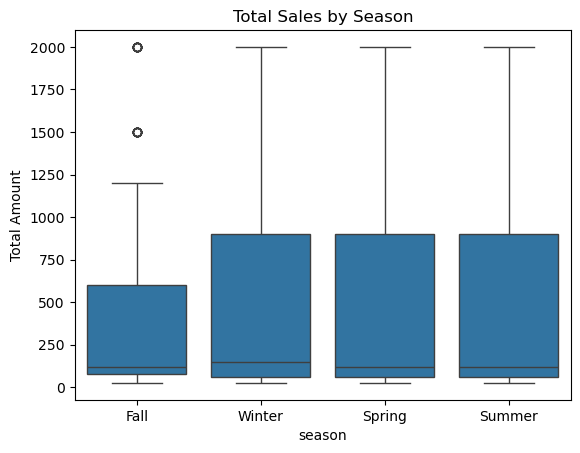

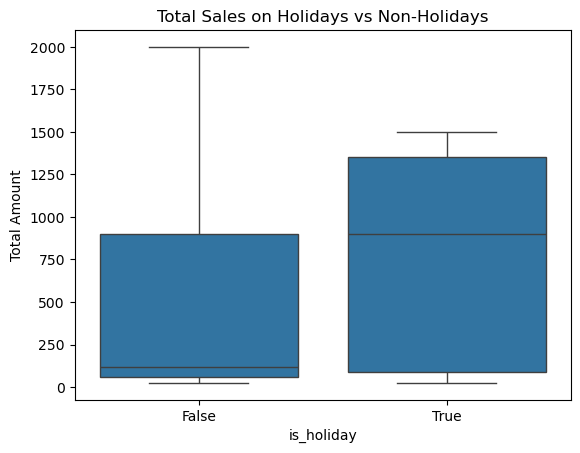

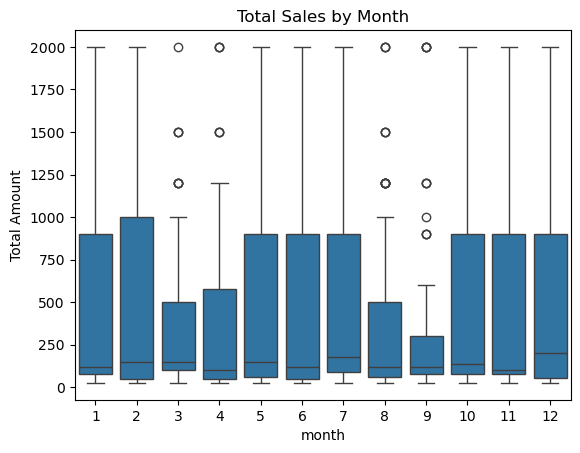

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot average sales by season
sns.boxplot(x='season', y='Total Amount', data=retail_data)
plt.title('Total Sales by Season')
plt.show()

# Plot sales on holidays vs non-holidays
sns.boxplot(x='is_holiday', y='Total Amount', data=retail_data)
plt.title('Total Sales on Holidays vs Non-Holidays')
plt.show()

# Plot sales by month
sns.boxplot(x='month', y='Total Amount', data=retail_data)
plt.title('Total Sales by Month')
plt.show()


### Feature Engineering

In [12]:
# Select relevant features (before one-hot encoding)
features = ['month', 'quarter', 'day_of_week', 'is_holiday']

# Convert 'season' to one-hot encoding and update the DataFrame
retail_data = pd.get_dummies(retail_data, columns=['season'], drop_first=True)

# Add the one-hot encoded 'season' columns to the features
season_columns = [col for col in retail_data.columns if col.startswith('season_')]
features.extend(season_columns)

# Define X (features) and y (target)
X = retail_data[features]
y = retail_data['Total Amount']

# Proceed with model training
print("Features used for training:", features)

Features used for training: ['month', 'quarter', 'day_of_week', 'is_holiday', 'season_Spring', 'season_Summer', 'season_Winter']


Before running the **SARIMA** model, we need to make sure 

- Double-check that all columns in X (features) and y (target variable, Total Amount) contain numeric data.
- If there are missing values (NaN), need to either fill them with appropriate values (like mean/median) or drop those rows.
- Ensure categorical columns (like is_holiday, and the one-hot encoded season_* columns) are correctly encoded as numerical values.

### Data Cleaning

In [13]:

# Ensure there are no missing values in features and target
retail_data = retail_data.dropna(subset=['Total Amount', 'month', 'quarter', 'day_of_week', 'is_holiday', 'season_Spring', 'season_Summer', 'season_Winter'])

# Target variable: 'Total Amount'
y = retail_data['Total Amount']

# Features (X) for training the model
X = retail_data[['month', 'quarter', 'day_of_week', 'is_holiday', 'season_Spring', 'season_Summer', 'season_Winter']]

# Ensure all features are numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Convert 'is_holiday' to a numeric type (1 for holiday, 0 for not)
X['is_holiday'] = X['is_holiday'].astype(int)

month            int32
quarter          int32
day_of_week      int32
is_holiday       int32
season_Spring    int32
season_Summer    int32
season_Winter    int32
dtype: object
int64


c:\Users\satis\miniconda3\envs\dsi_participant\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\satis\miniconda3\envs\dsi_participant\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\satis\miniconda3\envs\dsi_participant\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\satis\miniconda3\envs\dsi_participant\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\sat

RMSE for each fold: [753.5789035838496, 607.9299078888336, 589.6640688545693, 565.1489706909601, 522.0454413238208]
Average RMSE: 607.6734584684067
MAPE for each fold: [827.0853589428772, 319.8021086347316, 396.1784627805654, 398.76693783249607, 474.4695782062157]
Average MAPE: 483.26048927937717%
MASE for each fold: [1.6912496061216342, 1.0194184421049912, 1.1956969066405072, 1.1825926820455563, 1.433259999155288]
Average MASE: 1.3044435272135955


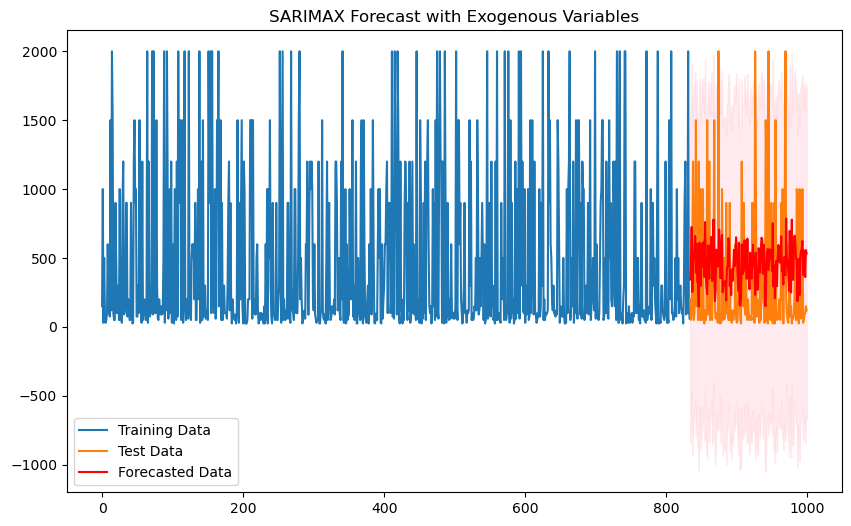

In [14]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to calculate MASE
def mean_absolute_scaled_error(y_true, y_pred, naive_forecast):
    mae_forecast = np.mean(np.abs(y_true - y_pred))
    mae_naive = np.mean(np.abs(y_true - naive_forecast))
    return mae_forecast / mae_naive

# Data Preparation
retail_data = retail_data.dropna(subset=['Total Amount', 'month', 'quarter', 'day_of_week', 'is_holiday', 
                                         'season_Spring', 'season_Summer', 'season_Winter'])
retail_data['Total Amount'] = pd.to_numeric(retail_data['Total Amount'], errors='coerce')
retail_data['season_Spring'] = retail_data['season_Spring'].astype(int)
retail_data['season_Summer'] = retail_data['season_Summer'].astype(int)
retail_data['season_Winter'] = retail_data['season_Winter'].astype(int)

# Features (X) and target variable (y)
X = retail_data[['month', 'quarter', 'day_of_week', 'is_holiday', 'season_Spring', 'season_Summer', 'season_Winter']]
X = X.apply(pd.to_numeric, errors='coerce')
X['is_holiday'] = X['is_holiday'].astype(int)
y = retail_data['Total Amount']

# Check data types
print(X.dtypes)
print(y.dtypes)

# Cross-Validation using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
rmse_scores = []
mape_scores = []
mase_scores = []

for train_index, test_index in tscv.split(X):
    # Split the data
    train_X, test_X = X.iloc[train_index], X.iloc[test_index]
    train_y, test_y = y.iloc[train_index], y.iloc[test_index]
    
    # Fit SARIMAX model
    sarimax_model = SARIMAX(train_y,
                           exog=train_X,
                           order=(1, 1, 1),
                           seasonal_order=(1, 1, 1, 12),
                           enforce_stationarity=False,
                           enforce_invertibility=False)
    sarimax_fit = sarimax_model.fit(disp=False)
    
    # Forecast
    forecast_steps = len(test_y)
    forecast = sarimax_fit.get_forecast(steps=forecast_steps, exog=test_X)
    forecast_mean = forecast.predicted_mean
    
    # Naive forecast for MASE
    naive_forecast = train_y.iloc[-1]
    naive_forecast_series = np.full(len(test_y), naive_forecast)
    
    # Metrics
    rmse = np.sqrt(mean_squared_error(test_y, forecast_mean))
    mape = mean_absolute_percentage_error(test_y, forecast_mean)
    mase = mean_absolute_scaled_error(test_y, forecast_mean, naive_forecast_series)
    
    rmse_scores.append(rmse)
    mape_scores.append(mape)
    mase_scores.append(mase)

# Print average metrics
print(f"RMSE for each fold: {rmse_scores}")
print(f"Average RMSE: {np.mean(rmse_scores)}")
print(f"MAPE for each fold: {mape_scores}")
print(f"Average MAPE: {np.mean(mape_scores)}%")
print(f"MASE for each fold: {mase_scores}")
print(f"Average MASE: {np.mean(mase_scores)}")

# Visualization for the last fold
plt.figure(figsize=(10, 6))
plt.plot(train_y, label='Training Data')
plt.plot(test_y, label='Test Data')
plt.plot(forecast_mean, label='Forecasted Data', color='red')
plt.fill_between(forecast_mean.index, 
                 forecast.conf_int().iloc[:, 0], 
                 forecast.conf_int().iloc[:, 1], 
                 color='pink', alpha=0.3)
plt.legend()
plt.title('SARIMAX Forecast with Exogenous Variables')
plt.show()


An Average MASE **1.30** indicates that the forecasting model is slightly worse than a naive baseline model. Here's how to interpret it:

- MASE < 1: The model performs better than the naive benchmark (e.g., last observed value as the forecast). This is the ideal scenario.

- MASE = 1: The model performs on par with the naive forecast.

- MASE > 1: The model performs worse than the naive forecast.

In [15]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm import tqdm  # For progress tracking

# Define a function for evaluating SARIMA models
def evaluate_sarima(train_y, test_y, train_X, test_X, order, seasonal_order):
    """
    Fits a SARIMAX model and calculates MASE, RMSE, MAE, and R-squared.
    """
    try:
        model = SARIMAX(train_y, 
                        exog=train_X, 
                        order=order, 
                        seasonal_order=seasonal_order,
                        enforce_stationarity=False, 
                        enforce_invertibility=False)
        results = model.fit(disp=False)
        forecast = results.get_forecast(steps=len(test_y), exog=test_X)
        forecast_mean = forecast.predicted_mean
        
        # Calculate evaluation metrics
        mase = np.mean(np.abs(forecast_mean - test_y)) / np.mean(np.abs(train_y.diff().dropna()))
        rmse = np.sqrt(mean_squared_error(test_y, forecast_mean))
        mae = mean_absolute_error(test_y, forecast_mean)
        r2 = r2_score(test_y, forecast_mean)  # Calculate R-squared
        
        return mase, rmse, mae, r2, results
    except Exception as e:
        return None, None, None, None, None  # Return None if the model fails

# Parameters to test
p_values = [0, 1, 2]
d_values = [0, 1]
q_values = [0, 1, 2]
P_values = [0, 1]
D_values = [0, 1]
Q_values = [0, 1]
m_values = [12]  # Monthly seasonality

# Data: Split into train and test sets
train_size = int(len(y) * 0.8)
train_y, test_y = y[:train_size], y[train_size:]
train_X, test_X = X[:train_size], X[train_size:]

# Grid search
best_score = float("inf")
best_params = None
results_list = []

for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in Q_values:
                        for m in m_values:
                            order = (p, d, q)
                            seasonal_order = (P, D, Q, m)
                            mase, rmse, mae, r2, model_results = evaluate_sarima(
                                train_y, test_y, train_X, test_X, order, seasonal_order
                            )
                            if mase is not None:
                                results_list.append((order, seasonal_order, mase, rmse, mae, r2))
                                if mase < best_score:
                                    best_score = mase
                                    best_params = (order, seasonal_order)

# Display the best parameters and metrics
print(f"Best SARIMA parameters: {best_params}")
print(f"Best MASE: {best_score}")

# Show top 5 combinations
sorted_results = sorted(results_list, key=lambda x: x[2])[:5]
print("Top 5 Results:")
for res in sorted_results:
    print(f"Order: {res[0]}, Seasonal Order: {res[1]}, MASE: {res[2]}, RMSE: {res[3]}, MAE: {res[4]}, R²: {res[5]}")


c:\Users\satis\miniconda3\envs\dsi_participant\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\satis\miniconda3\envs\dsi_participant\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\satis\miniconda3\envs\dsi_participant\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\satis\miniconda3\envs\dsi_participant\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\sat

Best SARIMA parameters: ((2, 1, 2), (0, 1, 1, 12))
Best MASE: 0.6113730956699969
Top 5 Results:
Order: (2, 1, 2), Seasonal Order: (0, 1, 1, 12), MASE: 0.6113730956699969, RMSE: 510.10663628063963, MAE: 350.24256205385194, R²: -0.12099525285374924
Order: (1, 1, 1), Seasonal Order: (1, 1, 1, 12), MASE: 0.6670573384239938, RMSE: 499.1230957851958, MAE: 382.1428729872525, R²: -0.0732407620829183
Order: (2, 1, 2), Seasonal Order: (1, 1, 1, 12), MASE: 0.679985981093375, RMSE: 505.2453542675625, MAE: 389.5494156769344, R²: -0.09973104214699391
Order: (2, 0, 1), Seasonal Order: (0, 0, 0, 12), MASE: 0.7152670341039845, RMSE: 498.0260281929999, MAE: 409.761175870359, R²: -0.06852800207443766
Order: (2, 0, 2), Seasonal Order: (1, 0, 1, 12), MASE: 0.7158613205800789, RMSE: 497.8056798222949, MAE: 410.1016298737416, R²: -0.06758268474290086


c:\Users\satis\miniconda3\envs\dsi_participant\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c:\Users\satis\miniconda3\envs\dsi_participant\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


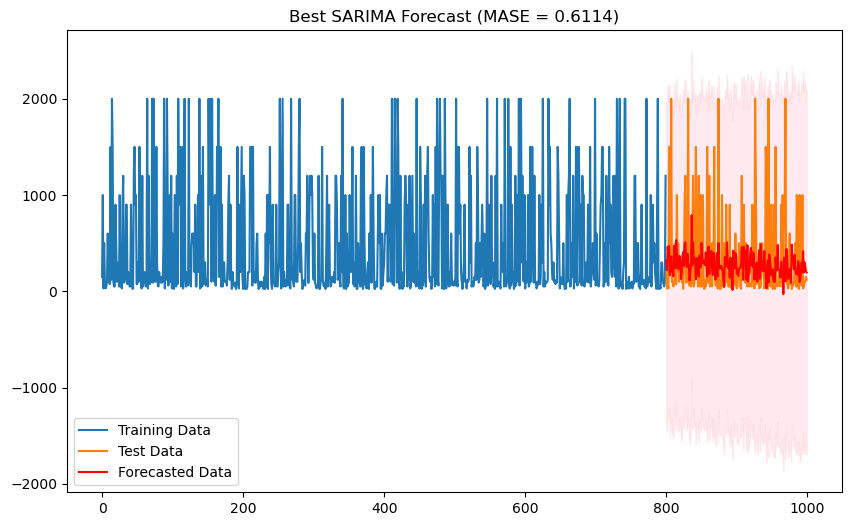

In [16]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Assuming you already have your best parameters and data
best_order = best_params[0]  # (p, d, q)
best_seasonal_order = best_params[1]  # (P, D, Q, m)

# Fit the best SARIMA model
sarimax_model_best = SARIMAX(train_y, 
                             exog=train_X, 
                             order=best_order, 
                             seasonal_order=best_seasonal_order,
                             enforce_stationarity=False, 
                             enforce_invertibility=False)

sarimax_fit_best = sarimax_model_best.fit(disp=False)

# Forecast the future
forecast_steps = len(test_y)
forecast_best = sarimax_fit_best.get_forecast(steps=forecast_steps, exog=test_X)
forecast_mean_best = forecast_best.predicted_mean
forecast_conf_int_best = forecast_best.conf_int()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train_y, label='Training Data')
plt.plot(test_y, label='Test Data')
plt.plot(forecast_mean_best, label='Forecasted Data', color='red')
plt.fill_between(forecast_mean_best.index, 
                 forecast_conf_int_best.iloc[:, 0], 
                 forecast_conf_int_best.iloc[:, 1], 
                 color='pink', alpha=0.3)
plt.legend()
plt.title(f'Best SARIMA Forecast (MASE = {best_score:.4f})')
plt.show()


A **MASE of around 0.61** might seem good at first glance, but it should be interpreted in the context of the **R² value -0.12**. A good MASE with a poor R² could mean your model performs well on certain aspects (like immediate forecast) but poorly in understanding the broader patterns.

To improve, consider using more advanced models like ARIMA, ETS, or Prophet, adding more relevant features, using cross-validation to tune parameters, and experimenting with ensemble methods.